## 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング
今回のテーマ
- 顧客属性データおよび、過去のキャンペーンでの接触情報に基づいて口座を開設したかを予測するモデルの構築
- [詳細はこちら](https://signate.jp/competitions/292)

In [1]:
# 必要なライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# データの読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('submit_sample.csv', header=None)
X = train.drop(columns=['id', 'y'])
y = train['y']

In [3]:
train.head(5)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [4]:
test.head(5)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


## 要約統計量、欠損値の確認

In [5]:
# 要約統計量
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.747565,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.569588,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [6]:
# 欠損値チェック
train.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## データ分析

正例の数： 24988
負例の数： 2112


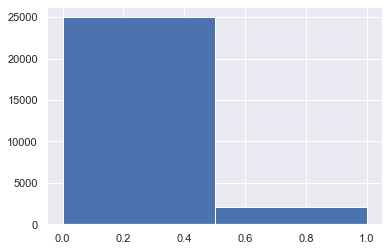

In [7]:
# y=1の出現率
print('正例の数：',train['y'].value_counts()[0])
print('負例の数：',train['y'].value_counts()[1])
plt.hist(train['y'], bins=2)
plt.show()

#### 各特徴量ごとに、カテゴリ別に口座開設率(y=1)を算出
yの出現率を辞書として変数宣言(後のtarget encodingに使用)

In [8]:
# 年代別の口座開設率(y=1)

# ageを年代別にカテゴリ分け
train['age_bin'] = '_'
for i in range(0, len(train)):
    if train.loc[i, 'age'] >= 20 and train.loc[i, 'age'] < 30:
        train.loc[i, 'age_bin'] = '20\'s'
    
    elif train.loc[i, 'age'] >= 30 and train.loc[i, 'age'] < 40:
        train.loc[i, 'age_bin'] = '30\'s'
        
    elif train.loc[i, 'age'] >= 40 and train.loc[i, 'age'] < 50:
        train.loc[i, 'age_bin'] = '40\'s'
    
    else:
        train.loc[i, 'age_bin'] = '50over'

In [9]:
# 各特徴量のカテゴリ別の確率を辞書型で変数宣言
job_dict = dict(train['y'].groupby(train['job']).mean())
marital_dict = dict(train['y'].groupby(train['marital']).mean())
education_dict = dict(train['y'].groupby(train['education']).mean())
contact_dict = dict(train['y'].groupby(train['contact']).mean())
month_dict = dict(train['y'].groupby(train['month']).mean())
day_dict = dict(train['y'].groupby(train['day']).mean())
campaign_dict = dict(train['y'].groupby(train['campaign']).mean())
previous_dict = dict(train['y'].groupby(train['previous']).mean())
poutcome_dict = dict(train['y'].groupby(train['poutcome']).mean())
age_bin_dict = dict(train['y'].groupby(train['age_bin']).mean())

In [10]:
# 各カテゴリの確率を出力
enc_list = [job_dict, marital_dict, education_dict, contact_dict, month_dict, campaign_dict,
                previous_dict, poutcome_dict, age_bin_dict]
name_list = ['job', 'marital', 'education', 'contact', 'month', 'campaign', 'previous', 'poutcome', 'age_bin']

for _, i in zip(name_list, enc_list):
    print('='*30)
    print('特徴量：'+_)
    for j in i:
        print((f'{j}のyの出現率：{round(i[j], 5)*100}%'))
        
print('='*30)

特徴量：job
admin.のyの出現率：8.66%
blue-collarのyの出現率：5.792%
entrepreneurのyの出現率：8.225%
housemaidのyの出現率：9.019%
managementのyの出現率：8.661000000000001%
retiredのyの出現率：16.733%
self-employedのyの出現率：9.629999999999999%
servicesのyの出現率：6.597%
studentのyの出現率：29.462%
technicianのyの出現率：4.293%
unemployedのyの出現率：13.459%
特徴量：marital
divorcedのyの出現率：6.4479999999999995%
marriedのyの出現率：6.2509999999999994%
singleのyの出現率：12.07%
特徴量：education
primaryのyの出現率：6.518%
secondaryのyの出現率：6.436999999999999%
tertiaryのyの出現率：10.45%
unknownのyの出現率：15.198999999999998%
特徴量：contact
cellularのyの出現率：9.135%
telephoneのyの出現率：8.967%
unknownのyの出現率：3.855%
特徴量：month
aprのyの出現率：20.349%
augのyの出現率：6.832000000000001%
febのyの出現率：14.865999999999998%
janのyの出現率：12.742%
julのyの出現率：8.679%
junのyの出現率：5.702999999999999%
marのyの出現率：46.262%
mayのyの出現率：4.4159999999999995%
novのyの出現率：6.285%
octのyの出現率：56.701%
sepのyの出現率：29.630000000000003%
特徴量：campaign
1のyの出現率：8.657%
2のyの出現率：6.718%
3のyの出現率：8.476%
4のyの出現率：5.147%
5のyの出現率：0.0%
特徴量：previous
0のyの出現率：6.7589999999999995%
1のyの出現率：11.82

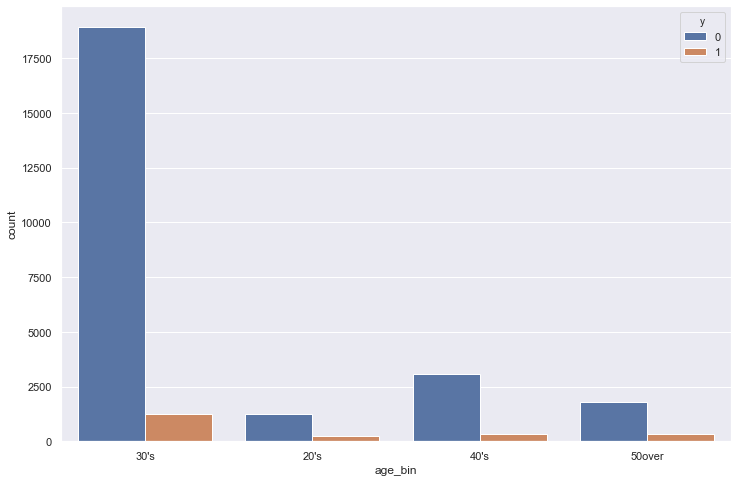

In [11]:
# 年代とyの関係をカウントプロット
plt.figure(figsize=(12,8))
sns.countplot(x='age_bin',hue='y',data=train)

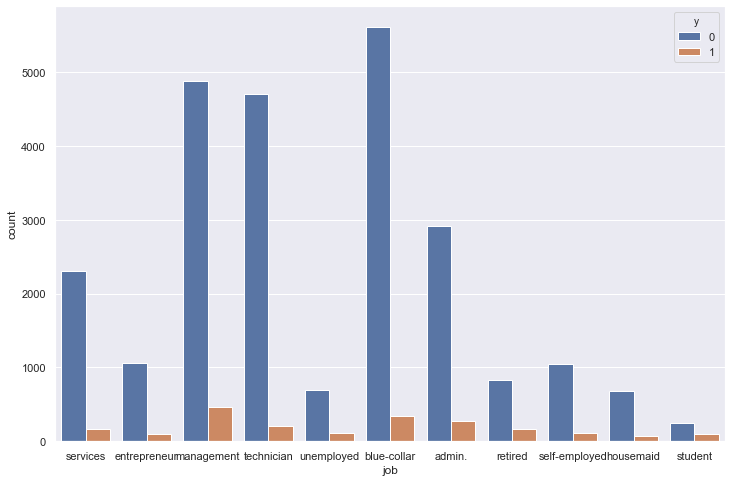

In [12]:
# jobとyの関係をカウントプロット
plt.figure(figsize=(12,8))
sns.countplot(x='job',hue='y',data=train)

#### 各特徴量に対してのカテゴリ変数ごとのyの出現率を考察
- job:学生と定年退職者が多い
- marital：未婚が多く、既婚と離婚はほぼ同等
- education：教育水準は大学卒業の人が多く、不明と続く
- contact：接触手段は固定電話と携帯電話が多くほぼ同等
- month：5月と10月が突出して多い
- campaign:特に傾向は見られない
- previous:2~3が多く、接触回数が多いほど開設率が高くなると言える
- poutcome:successが突出して多く、その他はほぼ同等
- age_bin：年齢層の低い人と高い人が多い

## 前処理を関数定義_1
- [default, housing, loan]のyes/no文字列を、バイナリ値に変換
- 年代別(10歳区切り)に分割
- age<=29が1,それ以外は0の特徴量'young'を作成
- job='student'が1,それ以外は0の特徴量'job_student'を作成
- month='mar'or'oct'が1,それ以外は0の特徴量'month_more'を作成
- poutcome='success'が1,それ以外は0の特徴量'poutcome_success'を作成

In [13]:
# 前処理を関数定義

def preprocessing(x):
    
#     ['default', 'housing', 'loan']をバイナリ値に変換
    x['default'] = x['default'].map({'yes':1, 'no':0})
    x['housing'] = x['housing'].map({'yes':1, 'no':0})
    x['loan'] = x['loan'].map({'yes':1, 'no':0})
    
#     年代別(10歳区切り)に分割
    x['age_bin'] = '_'
    for i in range(0, len(x)):
        if x.loc[i, 'age'] >= 20 and x.loc[i, 'age'] < 30:
            x.loc[i, 'age_bin'] = '20\'s'

        elif x.loc[i, 'age'] >= 30 and x.loc[i, 'age'] < 40:
            x.loc[i, 'age_bin'] = '30\'s'

        elif x.loc[i, 'age'] >= 40 and x.loc[i, 'age'] < 50:
            x.loc[i, 'age_bin'] = '40\'s'

        else:
            x.loc[i, 'age_bin'] = '50over'
            
#     age<=29が1,それ以外は0の特徴量'young'を作成
    x['young'] = 0
    for i in range(len(x)):
        if x.loc[i, 'age'] <= 29:
            x.loc[i, 'young'] = 1    
    
#     job='student'が1,それ以外は0の特徴量'job_student'を作成
    x['job_student'] = 0
    for i in range(len(x)):
        if x.loc[i, 'job'] == 'student':
            x.loc[i, 'job_student'] = 1
    
#     month='mar'or'oct'が1,それ以外は0の特徴量'month_more'を作成
    x['month_more'] = 0
    for i in range(len(x)):
        if x.loc[i, 'month'] == 'mar' or x.loc[i, 'month'] == 'oct':
            x.loc[i, 'month_more'] = 1
    
#     poutcome='success'が1,それ以外は0の特徴量'poutcome_success'を作成
    x['poutcome_success'] = 0
    for i in range(len(x)):
        if x.loc[i, 'poutcome'] == 'success':
            x.loc[i, 'poutcome_success'] = 1

    return x

## 特定の特徴量をtarget encoding

- ['age_bin', 'job', 'marital', 'education', 'contact', 'month', 'day', 'campaign', 'previous', 'poutcome']をtarget encoding

## 前処理を関数定義_2
- target encodingを適用
- 不要なカラムをドロップ

In [14]:
def preprocessing_2(x):
    
#     target encodingを適用
    enc_list = [job_dict, marital_dict, education_dict, contact_dict, month_dict, day_dict, campaign_dict,
                previous_dict, poutcome_dict, age_bin_dict]
    name_list = ['job', 'marital', 'education', 'contact', 'month', 'day', 'campaign', 'previous', 'poutcome', 'age_bin']

    for i in range(len(enc_list)):
        for j in range(len(x)):
            x.loc[j, name_list[i]+'_enc'] = enc_list[i][x.loc[j, name_list[i]]]
            
#     不要なカラムをドロップ
    x = x.drop(columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome', 'age_bin', 'day', 'campaign', 'previous'])
            
    return x

In [15]:
# 前処理を適用
X = preprocessing(X)
X = preprocessing_2(X)

# 前処理を行ったデータを標準化
scl = StandardScaler().fit_transform(X)
scl_X = pd.DataFrame(data=scl, columns=X.columns.values)
scl_X

,age,default,balance,housing,loan,duration,pdays,young,job_student,month_more,...,job_enc,marital_enc,education_enc,contact_enc,month_enc,day_enc,campaign_enc,previous_enc,poutcome_enc,age_bin_enc
0,-0.649067,-0.019213,-1.118127,0.844470,-0.381876,-0.626172,0.259840,-0.237414,-0.114881,-0.107746,...,-0.323548,-0.605068,-0.593669,0.585474,-0.237448,-0.690265,0.590565,-0.183903,-0.372057,-0.516685
1,-0.904943,-0.019213,-0.147105,-1.184175,-0.381876,-0.348037,1.068895,4.212049,-0.114881,-0.107746,...,0.116717,1.677969,1.162562,0.585474,-0.151313,0.300381,-0.930997,-0.183903,-0.086349,2.250160
2,-0.137314,-0.019213,-1.119454,0.844470,-0.381876,0.593720,1.560674,-0.237414,-0.114881,-0.107746,...,0.234468,-0.605068,1.162562,0.585474,-0.237448,0.528959,0.747710,-0.183903,-0.430409,-0.516685
3,-0.649067,-0.019213,1.625207,0.844470,2.618654,2.091747,-1.239292,-0.237414,-0.114881,-0.107746,...,-0.946277,-0.605068,-0.593669,-1.719353,-0.531753,-0.275108,-0.930997,-0.183903,-0.430409,-0.516685
4,1.525883,-0.019213,-0.179396,0.844470,-0.381876,-0.255325,-0.632500,-0.237414,-0.114881,-0.107746,...,1.531657,-0.605068,-0.557948,0.512488,1.976834,0.715777,0.747710,-0.183903,-0.086349,0.537097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,0.118562,-0.019213,-0.664195,0.844470,-0.381876,0.564442,-0.029675,-0.237414,-0.114881,-0.107746,...,-0.541172,-0.605068,-0.593669,0.585474,-0.531753,-1.080343,-2.290729,-0.183903,-0.086349,-0.516685
27096,-0.137314,-0.019213,-0.174814,0.844470,-0.381876,-0.528581,1.136316,-0.237414,-0.114881,-0.107746,...,-0.323548,-0.605068,-0.593669,0.585474,-0.531753,-1.080343,0.747710,-0.183903,-0.086349,-0.516685
27097,-0.137314,-0.019213,-0.415540,-1.184175,-0.381876,-0.255325,-1.235326,-0.237414,-0.114881,-0.107746,...,-0.323548,-0.605068,3.241164,0.585474,-0.329087,0.086090,-0.930997,-0.183903,-0.086349,-0.516685
27098,-0.777005,-0.019213,1.641005,0.844470,-0.381876,-0.528581,-1.318611,-0.237414,-0.114881,-0.107746,...,0.234333,1.677969,-0.593669,0.585474,-0.531753,-1.080343,0.747710,-0.183903,-0.086349,-0.516685


## 前処理を行ったデータで学習
- sklearnのGradientBoostingClassifierを使用
- グリッドサーチでハイパーパラメータをチューニング
- クロスバリデーションで交差検証

In [17]:
#調整したいパラメータを指定
param_grid={'n_estimators':[100,200,300],
            'learning_rate':[0.05,0.1,0.15],
            'min_samples_leaf':[3,4,5],
            'max_depth':[1,3,5]}

# グリッドサーチ
gcv = GridSearchCV(GradientBoostingClassifier(),param_grid,cv=5)
gcv.fit(scl_X,y)


#最適なパラメータを表示
gcv.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 3,
 'n_estimators': 200}

In [16]:
# モデルの定義
clf_gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, min_samples_leaf=3, max_depth=3, random_state=0)
clf_gb.fit(scl_X, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [17]:
# 交差検証
kfold = KFold(n_splits=5)
score_list = cross_val_score(clf_gb, scl_X, y, cv=kfold)
print(f'Cross-validation scores \n{score_list}')
ave_score = 0
for i in score_list:
    ave_score += i
    
print(f'average score \n{ave_score / len(score_list)}')

Cross-validation scores 
[0.93376384 0.92656827 0.93487085 0.93505535 0.9295203 ]
average score 
0.9319557195571957


## テストデータに前処理を適用
- テストデータの['job']には、学習データには含まれない'unknown'があるため、最頻値である'blue-collar'に置換する

In [18]:
for i in range(len(test)):
    if test.loc[i, 'job'] == 'unknown':
        test.loc[i, 'job'] = 'blue-collar'

test = test.drop(columns='id')

test = preprocessing(test)
test = preprocessing_2(test)

# 前処理を行ったデータを標準化
scl = StandardScaler().fit_transform(test)
scl_test = pd.DataFrame(data=scl, columns=test.columns.values)
scl_test

,age,default,balance,housing,loan,duration,pdays,young,job_student,month_more,...,job_enc,marital_enc,education_enc,contact_enc,month_enc,day_enc,campaign_enc,previous_enc,poutcome_enc,age_bin_enc
0,-0.140428,-0.014888,1.330993,-1.168350,-0.384138,-0.614562,-1.003128,-0.224762,-0.113608,-0.102039,...,-0.946238,1.671731,-0.579624,0.594988,1.154587,0.093882,-0.938106,6.640649,7.618319,-0.510084
1,0.113909,-0.014888,0.547006,0.855908,-0.384138,-0.341561,-0.776384,-0.224762,-0.113608,-0.102039,...,-0.318033,-0.607408,-0.579624,0.594988,0.158657,0.093882,0.590395,-0.188482,-0.086182,-0.510084
2,-0.649101,-0.014888,-0.494220,0.855908,-0.384138,-0.370298,-1.548107,-0.224762,-0.113608,-0.102039,...,-0.318033,1.671731,-0.579624,-1.692236,-0.527439,-0.938895,-0.938106,-0.188482,-0.086182,-0.510084
3,-0.649101,-0.014888,1.514763,0.855908,-0.384138,0.554070,0.214126,-0.224762,-0.113608,-0.102039,...,0.244755,-0.607408,-0.579624,0.594988,-0.527439,-1.075610,-0.938106,-0.188482,-0.086182,-0.510084
4,-0.521933,-0.014888,1.691923,-1.168350,-0.384138,-0.494825,0.993805,-0.224762,-0.113608,-0.102039,...,-0.318033,-0.607408,-0.579624,0.594988,0.812758,0.093882,0.748256,-0.188482,-0.373338,-0.510084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,1.639930,-0.014888,1.626970,0.855908,-0.384138,-0.614562,-0.076265,-0.224762,-0.113608,-0.102039,...,0.509310,-0.607408,1.198333,0.594988,0.158657,-0.304237,-0.938106,-0.188482,-0.431986,0.546987
18046,-0.267596,-0.014888,-0.557299,0.855908,-0.384138,0.554070,1.506961,-0.224762,-0.113608,-0.102039,...,-0.537571,-0.607408,-0.579624,0.594988,-0.527439,0.273151,0.748256,-0.188482,-0.086182,-0.510084
18047,-0.267596,-0.014888,1.496777,0.855908,-0.384138,-0.518772,-0.263228,-0.224762,-0.113608,-0.102039,...,0.244755,1.671731,-0.579624,-1.692236,-0.527439,-0.257089,-0.938106,-0.188482,-0.086182,-0.510084
18048,-0.649101,-0.014888,0.582311,0.855908,-0.384138,0.554070,-1.571975,-0.224762,-0.113608,-0.102039,...,-0.946238,1.671731,-0.579624,-1.692236,-0.527439,-0.938895,-0.938106,-0.188482,-0.086182,-0.510084


## 予測結果を確率で出力

In [19]:
predict = clf_gb.predict_proba(scl_test)
predict

array([[0.25029166, 0.74970834],
       [0.9487118 , 0.0512882 ],
       [0.97652978, 0.02347022],
       ...,
       [0.94245959, 0.05754041],
       [0.99180977, 0.00819023],
       [0.8856743 , 0.1143257 ]])

## 正例(y=1)の確率を提出

In [20]:
submit[1] = predict[:, 1]
submit

,0,1
0,0,0.749708
1,1,0.051288
2,2,0.023470
3,3,0.006431
4,4,0.060078
...,...,...
18045,18045,0.011887
18046,18046,0.017404
18047,18047,0.057540
18048,18048,0.008190


In [21]:
submit.to_csv('submit1.csv', index=False, header=False)

## 結果
- 評価関数「AUC（Area Under the Curve）」で、スコア：0.8517559
- 今回のコンペのランキングは180位/554位中
- スコアが0.85を超えたため、称号がbeginnerからIntermidiateに昇格